<a id='Title-Sequence-Processing-ConvNet'></a>
<h1 style="color:SlateGray;">Sequence Processing ConvNet</h1>

**Input dataset**

IMBD: a set of movie reviews with an adjustable limit on max word count.

Max Plank Institute Weather Station Data: a set of 14 different weather quantities taken at 10-minute intervals from 2009-2016.

**Output classification**

Binary categorization (positive/negative) of a movie review.

The weather 24 hours from the last data point seen by the network.

<h2 style="color:SlateGray;">Background</h2>

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*Embedding*](11_Word_Embeddings.ipynb#Layers-Embedding)

[*GRU*](13_Intermediate_Time_Series_RNN.ipynb#Layers-GRU)

<a id='Layers-Conv1D'></a>
*Conv1D*

Applies convolution to a 1D tensor input.

Uses a window of a specified length that slides through the indexes of the input tensor and performs a dot product on the values in the window with a weight matrix to extract features. Window can overlap, meaning values can be in multiple different windows.

<a id='Layers-MaxPooling1D'></a>
*MaxPooling1D*

Downsamples a 1D tensor by retaining only its most prominent values.

Filters out non-maximum values within a window on a 1D tensor input. The window is non-overlapping, meaning values cannot be in multiple windows.

<a id='Layers-GlobalMaxPooling1D'></a>
*GlobalMaxPooling1D*

Used to distill the most important, highest-level feature learned by the model and classify on it.

Effectively the same as [MaxPooling1D](#Layers-MaxPooling1D), except the window size is selected to be the length of the input tensor.

**Activations**

[*sigmoid*](02_Binary_Classification.ipynb#Activations-sigmoid)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*binary_crossentropy*](02_Binary_Classification.ipynb#Loss-functions-binary_crossentropy)

[*mae*](13_Intermediate_Time_Series_RNN.ipynb#Loss-functions-mae)

<h2 style="color:SlateGray;">Overview</h2>

Validates the usage of 1D CNNs to perform classification and regression on sequence data.

Instantiates a basic 1D CNN for NLP on 500 word sequences, followed by a slightly larger 1D CNN for predicting future temperatures based on the temperature data given for the previous ~3.8 years. The accuracy of the temperature predicting model is then improved by the inclusion of an RNN, against intuition this new model proves to be faster to train than a standalone RNN and just as accurate.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 9s 437us/step - loss: 0.8337 - acc: 0.5088 - val_loss: 0.6875 - val_acc: 0.5638
Epoch 2/10
20000/20000 [==============================] - 2s 119us/step - loss: 0.6700 - acc: 0.6401 - val_loss: 0.6642 - val_acc: 0.6582
Epoch 3/10
20000/20000 [==============================] - 2s 119us/step - loss: 0.6235 - acc: 0.7548 - val_loss: 0.6077 - val_acc: 0.7432
Epoch 4/10
20000/20000 [==============================] - 2s 120us/step - loss: 0.5257 - acc: 0.8092 - val_loss: 0.4850 - val_acc: 0.8068
Epoch 5/10
20000/20000 [==============================] - 2s 120us/step - loss: 0.4089 - acc: 0.8482 - val_loss: 0.4279 - val_acc: 0.8320
Epoch 6/10
20000/20000 [==============================] - 2s 125us/step - loss: 0.3492 - acc: 0.8669 - val_loss: 0.4221 - val_acc: 0.8362
Epoch 7/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.3094 - acc: 0.8645 - val_loss: 0.4446 - v

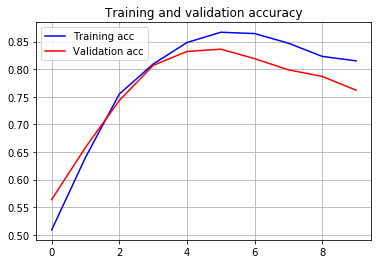

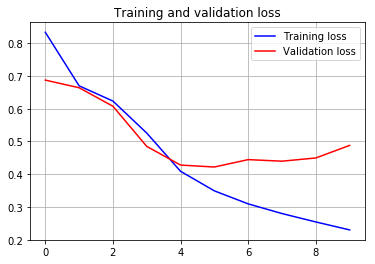

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [10]:
import time
ti = time.time()
retVal = model.evaluate(x_test, y_test)
tf = time.time()
print(f'evaluate_generator took {round(tf - ti, 2)}')
print(f'eval_loss was {retVal[0]}')
print(f'eval_acc was {retVal[1]}')

25000/25000 [==============================] - 2s 66us/step
evaluate_generator took 1.65
eval_loss was 0.4874480315208435
eval_acc was 0.7542


In [11]:
import os
import numpy as np

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [13]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [15]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4212 - val_loss: 0.4431
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3658 - val_loss: 0.4384
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3393 - val_loss: 0.4613
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3225 - val_loss: 0.4646
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3084 - val_loss: 0.4615
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3008 - val_loss: 0.4876
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2921 - val_loss: 0.5187
Epoch 8/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2867 - val_loss: 0.4767
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2793 - val_loss: 0.4645
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.274

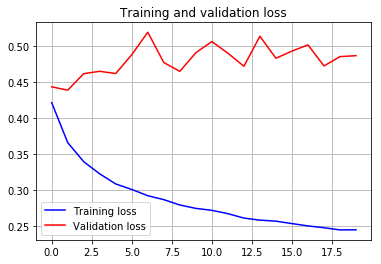

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [17]:
import time
ti = time.time()
retVal = model.evaluate_generator(test_gen, steps=100)
tf = time.time()
print(f'evaluate_generator took {round(tf - ti, 2)} and had a MAE of {retVal}')

evaluate_generator took 0.88 and had a MAE of 0.4258499326556921


In [18]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [19]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 79s 158ms/step - loss: 0.3435 - val_loss: 0.2836
Epoch 2/20
500/500 [==============================] - 78s 155ms/step - loss: 0.3053 - val_loss: 0.2762
Epoch 3/20
500/500 [==============================] - 78s 155ms/step - loss: 0.2938 - val_loss: 0.2767
Epoch 4/20
500/500 [==============================] - 76s 153ms/step - loss: 0.2841 - val_loss: 0.2761
Epoch 5/20
500/500 [==============================] - 76s 152ms/step - loss: 0.2770 - val_loss: 0.2863
Epoch 6/20
500/500 [==============================] - 76s 152ms/step - loss: 0.2698 - val_loss: 0.2976
Epoch 7/20
500/500 [==============================] - 76s 151ms/step - loss: 0.2650 - val_loss: 0.2933
Epoch 8/20
500/500 [==============================] - 76s 152ms/step - loss: 0.2594 - val_loss: 0.2904
Epoch 9/20
500/500 [==============================] - 76s 153ms/step - loss: 0.2543 - val_loss: 0.2798
Epoch 10/20
500/500 [==============================] - 76s 151ms/step - l

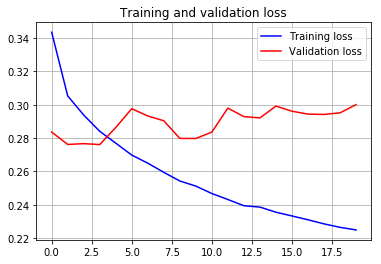

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [22]:
import time
ti = time.time()
retVal = model.evaluate_generator(test_gen, steps=250)
tf = time.time()
print(f'evaluate_generator took {round(tf - ti, 2)} and had a MAE of {retVal}')

evaluate_generator took 6.99 and had a MAE of 0.315469756051898
